# Baseline Model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Local Train / Test set paths

In [2]:
# Link to your sample train_path (manually selected for now)
local_train_path = '../raw_data/SAMPLES/TRAIN_5K'
local_test_path = '../raw_data/SAMPLES/TEST_5K'

## Cloud paths - TO DO

In [3]:
# Need to link to cloud storage account hosting all sample folders already ready to use by the model
cloud_train_path = '..'
cloud_test_path = '..'

## Preprocessing - Loading Train & Test images as Tensorflow generators

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
# ImageGenerator preprocess images / minimum params / to read .tif images
train_datagen = ImageDataGenerator(validation_split=0.2)
test_datagen = ImageDataGenerator()

In [6]:
# Load from directory to flow passsed into ImageGenerator
train_generator = train_datagen.flow_from_directory(local_train_path,
                                                    subset='training',
                                                    target_size=(96,96),
                                                    batch_size=16,
                                                    class_mode='binary')

val_generator = train_datagen.flow_from_directory(local_train_path,
                                                  subset='validation',
                                                  target_size=(96,96),
                                                  batch_size=16,
                                                  class_mode='binary')
                        

test_generator = test_datagen.flow_from_directory(local_test_path,
                                                  target_size=(96,96),
                                                  class_mode='binary')

Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Model

### Design and Init function

In [7]:
# INIT MODEL and COMPILE
from tensorflow.keras import layers, models
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

def init_model():
    model = models.Sequential()
    
    model.add(Rescaling(scale=1./255,input_shape=(96,96,3)))

    # Lets add convolution layers, 
    model.add(layers.Conv2D(32, kernel_size=2, activation='relu'))
    model.add(layers.MaxPooling2D(2))
  
    model.add(layers.Conv2D(32, kernel_size=2, activation="relu"))
    model.add(layers.MaxPooling2D(2))

    model.add(layers.Conv2D(32, kernel_size=2, activation="relu"))
    model.add(layers.MaxPooling2D(2))


    model.add(layers.Flatten())
    
    model.add(layers.Dense(30, activation='relu'))
  
    model.add(layers.Dense(1, activation='sigmoid'))

     ### Model compilation
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

### Model Training

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

In [9]:
model = init_model()
epochs = 15
batch_size = 32
es = EarlyStopping(patience=3, restore_best_weights=True,verbose=1)

history = model.fit(train_generator,
                    epochs = epochs,
                    validation_data=val_generator,
                    batch_size = batch_size, 
                    verbose = 1, 
                    callbacks = [es])

2022-09-08 13:29:22.182355: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/15
250/250 [==============================] - 24s 93ms/step - loss: 0.6226 - accuracy: 0.6300 - val_loss: 0.5527 - val_accuracy: 0.7220
Epoch 2/15
250/250 [==============================] - 26s 105ms/step - loss: 0.5133 - accuracy: 0.7558 - val_loss: 0.4692 - val_accuracy: 0.7860
Epoch 3/15
250/250 [==============================] - 24s 96ms/step - loss: 0.4994 - accuracy: 0.7653 - val_loss: 0.5337 - val_accuracy: 0.7430
Epoch 4/15
250/250 [==============================] - 24s 94ms/step - loss: 0.4744 - accuracy: 0.7875 - val_loss: 0.5103 - val_accuracy: 0.7590
Epoch 5/15
250/250 [==============================] - 24s 95ms/step - loss: 0.4641 - accuracy: 0.7885 - val_loss: 0.4432 - val_accuracy: 0.7960
Epoch 6/15
250/250 [==============================] - 24s 95ms/step - loss: 0.4451 - accuracy: 0.7970 - val_loss: 0.4469 - val_accuracy: 0.7950
Epoch 7/15
250/250 [==============================] - 24s 95ms/step - loss: 0.4219 - accuracy: 0.8140 - val_loss: 0.4458 - val_accuracy

### Plot Loss & Accuracy charts

In [10]:
# Plot loss history function
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(16,4))
    
    # --- LOSS --- 
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0.3,0.8))
    ax[0].legend(['Train', 'Val'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- ACCURACY
    
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Val'], loc='best')
    ax[1].set_ylim((0.5,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
    
    if title:
        fig.suptitle(title)

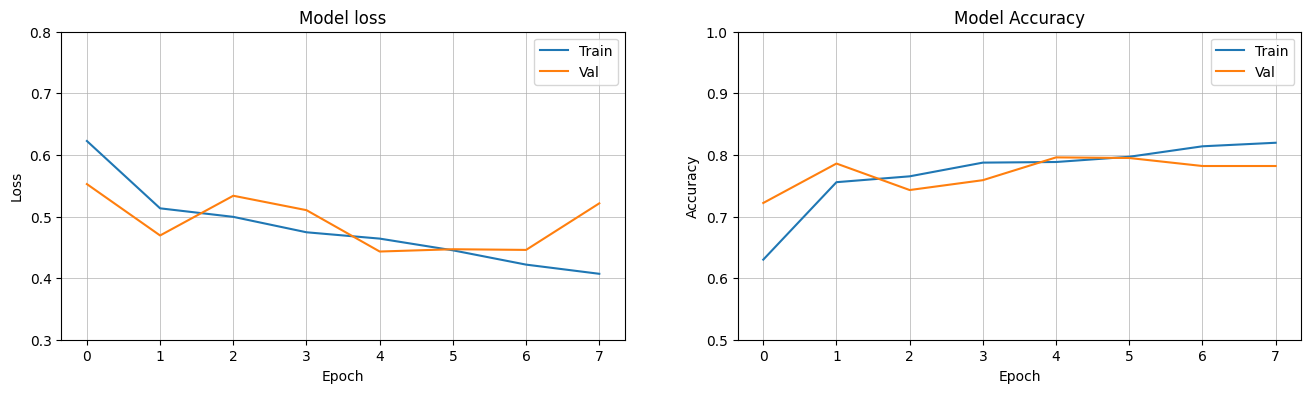

In [11]:
# Plot the loss & accuracy curves
plot_loss_accuracy(history)

### Model Evaluation

In [12]:
results = model.evaluate(test_generator, verbose = 1 )
print(f'The accuracy on the test set is of {results[1]*100:.2f} %')

32/32 [==============================] - 2s 62ms/step - loss: 0.4263 - accuracy: 0.8010
The accuracy on the test set is of 80.10 %


In [2]:
from google.cloud import storage
from project_cancer_detection.ml_logic.params import PROJECT,BUCKET_NAME

# get default project id
client = storage.Client()
bucket = storage.Bucket(client, BUCKET_NAME, user_project=PROJECT)
#blobs = bucket.list_blobs()
url = 'https://storage.googleapis.com/cancer-detection-small-datasets/test_1k/0/01132f290bf88852e10d23ea2f6f5557ba624f74.tif'
blob = bucket.blob('/test_1k/0/01132f290bf88852e10d23ea2f6f5557ba624f74.tif')
blob.download_to_filename('test.tif')


Forbidden: 403 GET https://storage.googleapis.com/download/storage/v1/b/cancer-detection-small-datasets/o/%2Ftest_1k%2F0%2F01132f290bf88852e10d23ea2f6f5557ba624f74.tif?alt=media&userProject=ethereal-runner-356713: le-wagon-bootcamp@wagon-bootcamp-991.iam.gserviceaccount.com does not have serviceusage.services.use access to the Google Cloud project.: ('Request failed with status code', 403, 'Expected one of', <HTTPStatus.OK: 200>, <HTTPStatus.PARTIAL_CONTENT: 206>)

In [11]:
bucket = storage.Bucket(gs://cancer-detection-small-datasets)

SyntaxError: invalid syntax (4209936853.py, line 1)